Hadia Trik

Misbah Noor Awan

Muhammad Ali Usman


<br>BESE-11A

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

In [ ]:
data = pd.read_csv("london_merged.csv")

**Metadata:**<br>
"timestamp" - timestamp field for grouping the data<br>
"cnt" - the count of a new bike shares<br>
"t1" - real temperature in C<br>
"t2" - temperature in C "feels like"<br>
"hum" - humidity in percentage<br>
"wind_speed" - wind speed in km/h<br>
"weather_code" - category of the weather<br>
"is_holiday" - boolean field - 1 holiday / 0 non holiday<br>
"is_weekend" - boolean field - 1 if the day is weekend<br>
"season" - category field meteorological seasons: <br>0-spring ; 1-summer; 2-fall; 3-winter.

"weather_code" category description:<br>
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

In [ ]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


# Checking for empty or nan values

In [ ]:
data.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

**No null values found.**

In [ ]:
data.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

**No NaN values found.**

# Checking for Duplicate Values

In [ ]:
print(data.duplicated().sum())

0


# Analysis of categorical attributes

Now we analyze the value counts for various attributes. We do not need to analyze the value counts for continuous data like cnt, t1, t2, hum, wind_speed.<br>
We will check the counts of categorical attributes: weather_code, is_holiday, is_weekend, and the season.



0.0    4394
1.0    4387
3.0    4330
2.0    4303
Name: season, dtype: int64


<Axes: xlabel='season', ylabel='count'>

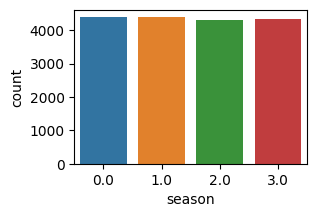

In [ ]:
print(data['season'].value_counts())
plt.figure(figsize=(3,2))
sns.countplot(x=data['season'])

All the unique values of season have almost equal number of data samples.

0.0    12444
1.0     4970
Name: is_weekend, dtype: int64


<Axes: xlabel='is_weekend', ylabel='count'>

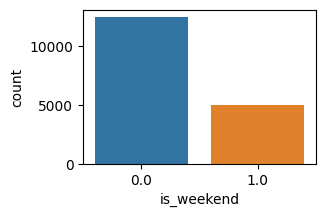

In [ ]:
print(data['is_weekend'].value_counts())
plt.figure(figsize=(3,2))
sns.countplot(x=data['is_weekend'])

Weekends have more data samples

0.0    17030
1.0      384
Name: is_holiday, dtype: int64


<Axes: xlabel='is_holiday', ylabel='count'>

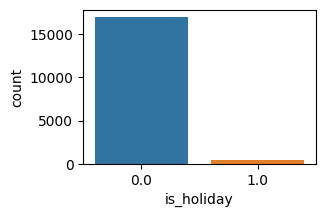

In [ ]:
print(data['is_holiday'].value_counts())
plt.figure(figsize=(3,2))
sns.countplot(x=data['is_holiday'])

Holidays have less number of data samples.

1.0     6150
2.0     4034
3.0     3551
7.0     2141
4.0     1464
26.0      60
10.0      14
Name: weather_code, dtype: int64


<Axes: xlabel='weather_code', ylabel='count'>

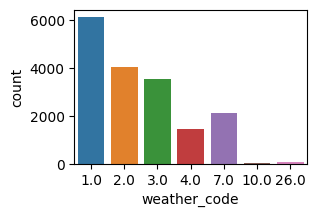

In [ ]:
print(data['weather_code'].value_counts())
plt.figure(figsize=(3,2))
sns.countplot(x=data['weather_code'])

weather_code 26.0 and 10.0 have small number of data samples. This might cause our model to overfit. weather_code 96.0 has no occurence in data at all.<br>
To solve this problem, we combine all of these (10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog) into a single category "99.0 = extreme weather".

In [ ]:
# frequency of each category
counts = data['weather_code'].value_counts()

# threshold for rare categories
threshold = 100

# finding the categories that occur less than the threshold
rare_occ = counts[counts < threshold].index.tolist()

# combine rare categories into a new category called 99
data['weather_code'] = data['weather_code'].apply(lambda x: 99 if x in rare_occ else x)

1.0     6150
2.0     4034
3.0     3551
7.0     2141
4.0     1464
99.0      74
Name: weather_code, dtype: int64


<Axes: xlabel='weather_code', ylabel='count'>

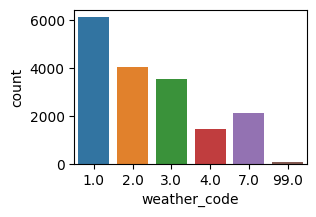

In [ ]:
print(data['weather_code'].value_counts())
plt.figure(figsize=(3,2))
sns.countplot(x=data['weather_code'])

# Analysis of attributes with continuous values

To detect and remove handle outliers in the continuous attributes i.e. t1, t2, hum, cnt, and wind_speed, we will ise IQR approach. We will visualize these attributes using box plot, remove the outliers using IQR approach and visualize them again to see the difference.

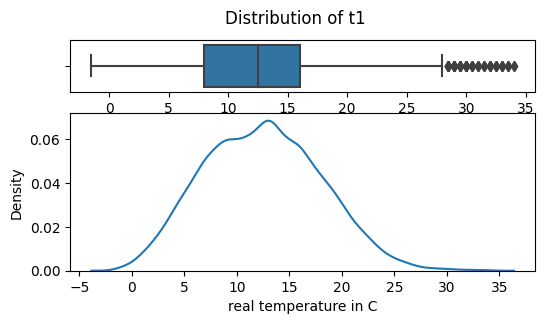

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 3), height_ratios=(0.25, 0.75))
# boxplot of t1
sns.boxplot(x=data['t1'], ax=ax1)
ax1.set_xlabel("real temperature in C")
# line plot of t1
sns.kdeplot(x=data['t1'], ax=ax2)
ax2.set_xlabel("real temperature in C")

fig.suptitle("Distribution of t1")
plt.show()

In [ ]:
# IQR Approach
q1, q3 = np.percentile(data['t1'], 25), np.percentile(data['t1'], 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

# count the number of outliers
outliers = np.sum((data['t1'] < lower_bound) | (data['t1'] > upper_bound))

# Removing the outliers
data['t1'] = data['t1'][(data['t1'] >= lower_bound) & (data['t1'] <= upper_bound)]
# Remove rows with NaN values in t1 column
data = data.dropna(subset=['t1'])
print("Number of removed outliers: ", outliers)

Number of removed outliers:  64


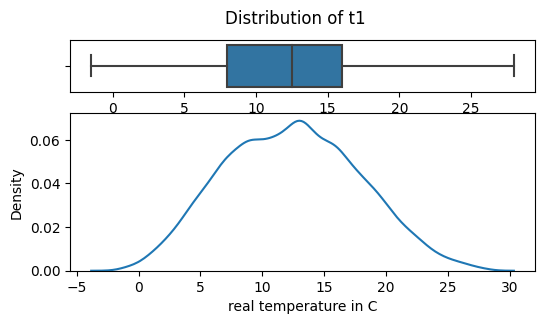

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 3), height_ratios=(0.25, 0.75))
# boxplot of t1
sns.boxplot(x=data['t1'], ax=ax1)
ax1.set_xlabel("real temperature in C")
# line plot of t1
sns.kdeplot(x=data['t1'], ax=ax2)
ax2.set_xlabel("real temperature in C")

fig.suptitle("Distribution of t1")
plt.show()

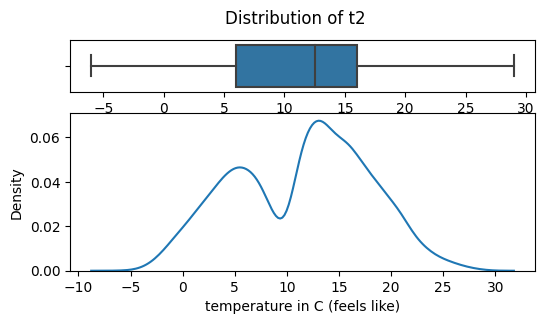

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 3), height_ratios=(0.25, 0.75))
# boxplot of t2
sns.boxplot(x=data['t2'], ax=ax1)
ax1.set_xlabel("temperature in C (feels like)")
# line plot of t2
sns.kdeplot(x=data['t2'], ax=ax2)
ax2.set_xlabel("temperature in C (feels like)")

fig.suptitle("Distribution of t2")
plt.show()

In [ ]:
# IQR Approach
q1, q3 = np.percentile(data['t2'], 25), np.percentile(data['t2'], 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

# count the number of outliers
outliers = np.sum((data['t2'] < lower_bound) | (data['t2'] > upper_bound))

# Removing the outliers
data['t2'] = data['t2'][(data['t2'] >= lower_bound) & (data['t2'] <= upper_bound)]
# Remove rows with NaN values in t2 column
data = data.dropna(subset=['t2'])
print("Number of removed outliers: ", outliers)

Number of removed outliers:  0


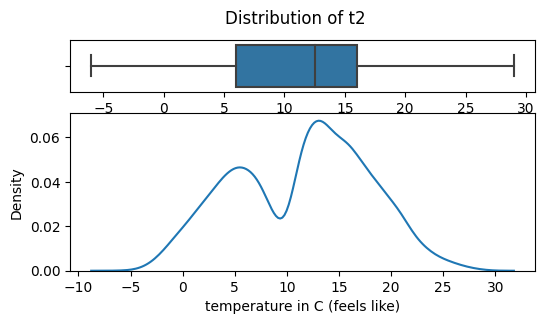

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 3), height_ratios=(0.25, 0.75))
# boxplot of t2
sns.boxplot(x=data['t2'], ax=ax1)
ax1.set_xlabel("temperature in C (feels like)")
# line plot of t2
sns.kdeplot(x=data['t2'], ax=ax2)
ax2.set_xlabel("temperature in C (feels like)")

fig.suptitle("Distribution of t2")
plt.show()

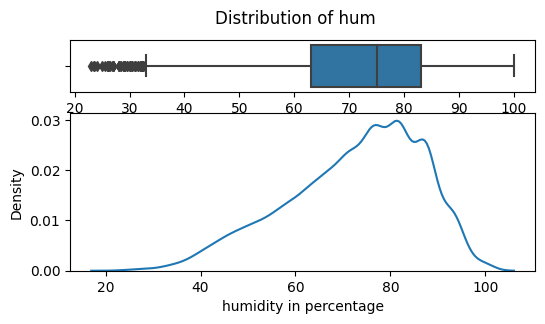

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 3), height_ratios=(0.25, 0.75))
# boxplot of hum
sns.boxplot(x=data['hum'], ax=ax1)
ax1.set_xlabel("humidity in percentage")
# line plot of hum
sns.kdeplot(x=data['hum'], ax=ax2)
ax2.set_xlabel("humidity in percentage")

fig.suptitle("Distribution of hum")
plt.show()

In [ ]:
# IQR Approach
q1, q3 = np.percentile(data['hum'], 25), np.percentile(data['hum'], 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

# count the number of outliers
outliers = np.sum((data['hum'] < lower_bound) | (data['hum'] > upper_bound))

# Removing the outliers
data['hum'] = data['hum'][(data['hum'] >= lower_bound) & (data['hum'] <= upper_bound)]
# Remove rows with NaN values in hum column
data = data.dropna(subset=['hum'])
print("Number of removed outliers: ", outliers)

Number of removed outliers:  63


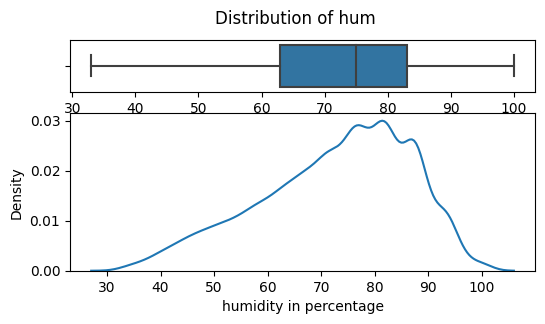

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 3), height_ratios=(0.25, 0.75))
# boxplot of hum
sns.boxplot(x=data['hum'], ax=ax1)
ax1.set_xlabel("humidity in percentage")
# line plot of hum
sns.kdeplot(x=data['hum'], ax=ax2)
ax2.set_xlabel("humidity in percentage")

fig.suptitle("Distribution of hum")
plt.show()

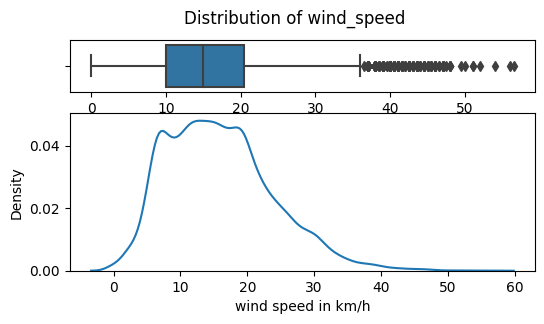

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 3), height_ratios=(0.25, 0.75))
# boxplot of wind_speed
sns.boxplot(x=data['wind_speed'], ax=ax1)
ax1.set_xlabel("wind speed in km/h")
# line plot of wind_speed
sns.kdeplot(x=data['wind_speed'], ax=ax2)
ax2.set_xlabel("wind speed in km/h")

fig.suptitle("Distribution of wind_speed")
plt.show()

In [ ]:
# IQR Approach
q1, q3 = np.percentile(data['wind_speed'], 25), np.percentile(data['wind_speed'], 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

# count the number of outliers
outliers = np.sum((data['wind_speed'] < lower_bound) | (data['wind_speed'] > upper_bound))

# Removing the outliers
data['wind_speed'] = data['wind_speed'][(data['wind_speed'] >= lower_bound) & (data['wind_speed'] <= upper_bound)]
# Remove rows with NaN values in wind_speed column
data = data.dropna(subset=['wind_speed'])
print("Number of removed outliers: ", outliers)

Number of removed outliers:  236


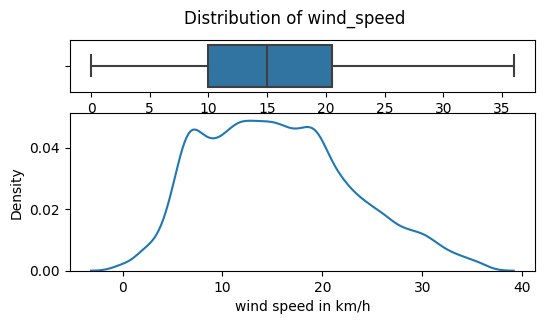

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 3), height_ratios=(0.25, 0.75))
# boxplot of wind_speed
sns.boxplot(x=data['wind_speed'], ax=ax1)
ax1.set_xlabel("wind speed in km/h")
# line plot of wind_speed
sns.kdeplot(x=data['wind_speed'], ax=ax2)
ax2.set_xlabel("wind speed in km/h")

fig.suptitle("Distribution of wind_speed")
plt.show()

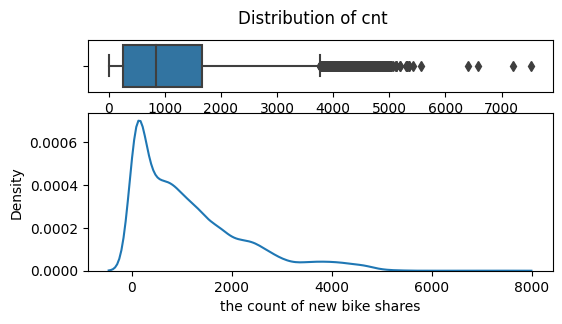

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 3), height_ratios=(0.25, 0.75))
# boxplot of cnt
sns.boxplot(x=data['cnt'], ax=ax1)
ax1.set_xlabel("the count of new bike shares")
# line plot of cnt
sns.kdeplot(x=data['cnt'], ax=ax2)
ax2.set_xlabel("the count of new bike shares")

fig.suptitle("Distribution of cnt")
plt.show()

We need to transform cnt as there are a lot of outliers. Boxcox transformation is suitable here. Since we may have zeros in cnt, we apply a shifted boxcox transformation by adding 1.

In [ ]:
#Transforming cnt using shifted square root transformation
new_cnt = np.sqrt(data['cnt'])
data['cnt'] = new_cnt

In [ ]:
# IQR Approach
q1, q3 = np.percentile(data['cnt'], 25), np.percentile(data['cnt'], 75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

# count the number of outliers
outliers = np.sum((data['cnt'] < lower_bound) | (data['cnt'] > upper_bound))

# Removing the outliers
data['cnt'] = data['cnt'][(data['cnt'] >= lower_bound) & (data['cnt'] <= upper_bound)]
# Remove rows with NaN values in wind_speed column
data = data.dropna(subset=['cnt'])
print("Number of removed outliers: ", outliers)

Number of removed outliers:  4


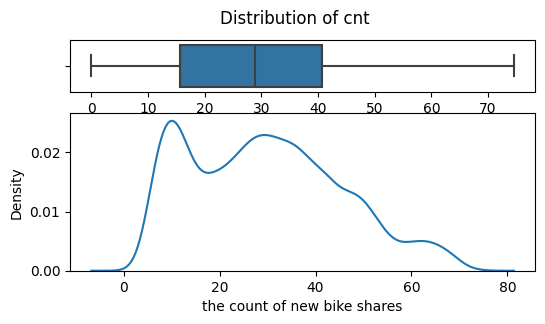

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 3), height_ratios=(0.25, 0.75))
# boxplot of cnt
sns.boxplot(x=data['cnt'], ax=ax1)
ax1.set_xlabel("the count of new bike shares")
# line plot of cnt
sns.kdeplot(x=data['cnt'], ax=ax2)
ax2.set_xlabel("the count of new bike shares")

fig.suptitle("Distribution of cnt")
plt.show()

# Expanding the timestamp

For better understanding of the data, we will split the timestamp into year, month, day_in_month, and hour_in_day.

In [ ]:
# Convert the timestamp attribute into datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Extract the year, month, day_in_month, and hour_in_day from the timestamp column
data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['day_in_month'] = data['timestamp'].dt.day
data['day_in_week'] = data['timestamp'].dt.weekday
data['hour_in_day'] = data['timestamp'].dt.hour

# Drop the original timestamp column
data.drop(['timestamp'], axis=1, inplace=True)

In [ ]:
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day_in_month,day_in_week,hour_in_day
0,13.490738,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1,4,6,0
1,11.747340,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1,4,6,1
2,11.575837,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1,4,6,2
3,8.485281,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1,4,6,3
4,6.855655,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1,4,6,4


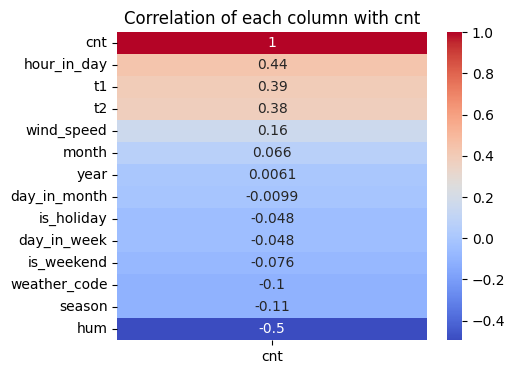

In [ ]:
# Plot heatmap of correlation matrix
plt.figure(figsize=(5, 4))
sns.heatmap(data.corr()[['cnt']].sort_values(by='cnt', ascending=False), cmap='coolwarm', annot=True)
plt.title('Correlation of each column with cnt')
plt.show()

The year and day_in_month will not add any value to our model so we can drop them.

In [ ]:
data.drop(['day_in_month', 'year'], axis=1, inplace=True)
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,month,day_in_week,hour_in_day
0,13.490738,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,1,6,0
1,11.747340,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,1
2,11.575837,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,1,6,2
3,8.485281,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,1,6,3
4,6.855655,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,1,6,4


# Encoding categorical data and splitting data into training and testing sets

is_holiday and is_weekend are also categorical but we do not need to encode them because they are already in binary.

In [ ]:
# categorical columns
cat_cols = ['weather_code', 'season', 'month', 'day_in_week', 'hour_in_day']

# Encode categorical columns using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cols = pd.DataFrame(encoder.fit_transform(data[cat_cols]))

# Replace categorical columns with encoded columns in the dataset
data_encoded = data.drop(cat_cols, axis=1)
data_encoded = pd.concat([data_encoded.reset_index(drop=True), encoded_cols.reset_index(drop=True)], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X = data_encoded.drop(['cnt'], axis=1)
y = data_encoded['cnt']

X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32, shuffle=True)


# Training

##Through Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Create a Linear Regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

y_preds = model.predict(X_train)
y_preds_ = model.predict(X_test)

# Evaluate the performance of the model using R-squared score
r21 = r2_score(y_train, y_preds)
r22 = r2_score(y_test, y_preds_)
print('R-squared score:', r21)
print('R-squared score:', r22)

R-squared score: 0.785100004018948
R-squared score: 0.8002021608937266


##Through Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)

# fit the model to the training data
rf_model.fit(X_train, y_train)

y_preds = rf_model.predict(X_train)
y_preds_ = rf_model.predict(X_test)

# Evaluate the performance of the model using R-squared score
r21 = r2_score(y_train, y_preds)
r22 = r2_score(y_test, y_preds_)
print('R-squared score:', r21)
print('R-squared score:', r22)

R-squared score: 0.9941810576071703
R-squared score: 0.9578930766848409


##Through Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.3, random_state=42)

# fit the model to the training data
gb_model.fit(X_train, y_train)

y_preds = gb_model.predict(X_train)
y_preds_ = gb_model.predict(X_test)

# Evaluate the performance of the model using R-squared score
r21 = r2_score(y_train, y_preds)
r22 = r2_score(y_test, y_preds_)
print('R-squared score:', r21)
print('R-squared score:', r22)

R-squared score: 0.9474559298250834
R-squared score: 0.9450420675047491


##Through Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras

# Define the model
model = keras.Sequential([
    keras.layers.Dense(1, input_shape=[len(X_train.columns)])
])

# Compile the model
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(0.001))

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, verbose=0)


In [ ]:
y_preds = model.predict(X_train)
y_preds_ = model.predict(X_test)

# Evaluate the performance of the model using R-squared score
r21 = r2_score(y_train, y_preds)
r22 = r2_score(y_test, y_preds_)
print('R-squared score:', r21)
print('R-squared score:', r22)

160/160 [==============================] - 0s 1ms/step
R-squared score: 0.7814768713856983
R-squared score: 0.7968349587955732


Comparing scores of all 4 models (70:30), we observe that Random Forest regressor has a score of 0.945 and Neural Network (no hidden layers) has score of 0.795.

NN's require more computational resources and longer training times, may be prone to overfitting if not optimized properly, and can be more difficult to interpret than other models.



#Analysing Overfitting on Random Forest Regressor through varying train-test sizes

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=500, random_state=42)

values=[i/10 for i in range(1,10)]
test_score=[]
train_score=[]

for i in values:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=32, shuffle=True)
  # fit the model to the training data
  rf_model.fit(X_train, y_train)

  y_preds = rf_model.predict(X_train)
  y_preds_ = rf_model.predict(X_test)

  # Evaluate the performance of the model using R-squared score
  r21 = r2_score(y_train, y_preds)
  r22 = r2_score(y_test, y_preds_)

  train_score.append(r21)
  test_score.append(r22)

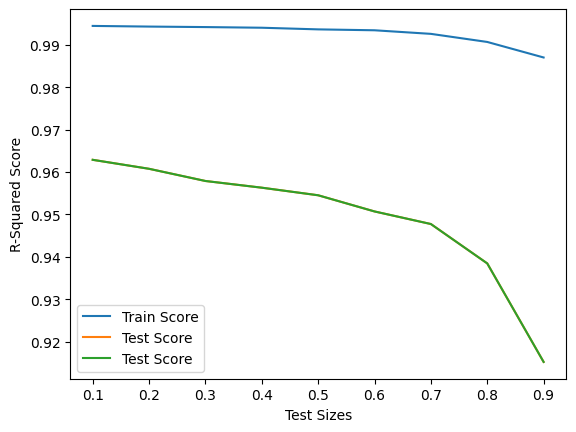

In [ ]:
#plot line graph of varying test_size values against train and test score
sns.lineplot(x=values,y=train_score,label="Train Score")
sns.lineplot(x=values,y=test_score,label="Test Score")
sns.lineplot(x=values,y=test_score,label="Test Score")

plt.xlabel("Test Sizes")
plt.ylabel("R-Squared Score")

plt.show()

In [ ]:
difference=[]
for i in range(0,len(train_score)):
  difference.append(train_score[i]-test_score[i])
index = difference.index(min(difference))
print("Minumum Difference:" , min(difference), " at Index:", index)
print("Train Size at Index: ", 1 - values[index])



Minumum Difference: 0.03156680303237647  at Index: 0
Train Size at Index:  0.9


In [ ]:
print(difference)

[0.03156680303237647, 0.03352988649162347, 0.03628798092232943, 0.03771235887721658, 0.03911222759897237, 0.04271273935664732, 0.04483520466397839, 0.05221112360235247, 0.07177531269055992]


#Conclusion
Through training of Neural Networks with no hidden layers, r2 score on test set was 0.79, while test score for Random Forest regression was 0.95. Adding 1 hidden layer to the NN increased the r2 score to 0.95 but the training time also increases.

In NN regressor, regularization techniques such as dropout and weight decay can be used to avoid overfitting. Furthermore, RFR have fewer hyperparameters to tune than Neural Network Regressor, so finding the optimal set of hyperparameters for a RFR can be time-consuming and requires careful experimentation. On the other hand, Neural Network Regressors have a large number of hyperparameters which can be used to tune the model more efficiently.

Hence we have selected Neural Network Regressor as an appropriate model for this dataset.


# Model Improvement

## Splitting the data into training, validation, and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=22, shuffle=True)

## Tuning the Hyperparameters

Through repetitive runs of GridSearchCV on different sets of hyperparameters, we found that the best models are the ones with less number of hidden layers, more nodes at each layer and the learning rates between 0.001 to 0.01.

Models with less number of hidden layer work best because the complexity of the model increases with the increase in hidden layers which leads to overfitting.

Code used to try different sets of hyperparameters is given below.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define the base model for grid search
def create_model(num_hidden_layers=1, num_neurons=32, activation='relu', dropout_rate=0.0, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_shape=[len(X_train.columns)]))
    for i in range(num_hidden_layers-1):
        model.add(Dense(num_neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    return model

# Create the KerasRegressor wrapper for grid search
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameter grid for grid search
param_grid = {
    'num_hidden_layers': [1, 2, 3, 4],
    'num_neurons': [8, 16, 32, 64],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'dropout_rate': [0.0, 0.05, 0.1, 0.2],
    'learning_rate': [0.1, 0.01, 0.001, 0.0001]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


## Finding the Best Model

We have narrowed down the set of hyperparameters using GridSearchCV.

Now we will train the model on learning rates 0.001, 0.003 and 0.009 with 1, 2 or 3 hidden layers each having 8, 16, 32 or 64 nodes to further optimize the hyperparameters.

The R2 score for both testing and training set will be checked for each model to monitor the generalization gap.


In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

scores = list()

layers = [1,2,3]
lrs = [0.001, 0.003, 0.009]
nodes = [8,16,32,64]
for layer in layers:
  for l_rate in lrs:
    for node in nodes:
      model = Sequential()
      model.add(Dense(node, activation='relu', input_shape=[len(X_train.columns)]))
      for i in range(layer-1):
        model.add(Dense(node, activation='relu'))
      model.add(Dense(1))
      optimizer = tf.keras.optimizers.Adam(l_rate)
      model.compile(loss='mse',
            optimizer=tf.keras.optimizers.Adam(l_rate))
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, verbose=0)
      y_preds = model.predict(X_train)
      y_preds_ = model.predict(X_test)

      # Evaluate the performance of the model using R-squared score
      r21 = r2_score(y_train, y_preds)
      r22 = r2_score(y_test, y_preds_)
      score = [r21, r22, {'layers':layer, 'activation':'relu', 'lr':l_rate, 'nodes':node}]
      scores.append(score)
      print(score)
      


134/134 [==============================] - 0s 1ms/step
[0.9423256965684147, 0.9430795582197437, {'layers': 1, 'activation': 'relu', 'lr': 0.001, 'nodes': 8}]
134/134 [==============================] - 0s 2ms/step
[0.9594561642103615, 0.9575871226566028, {'layers': 1, 'activation': 'relu', 'lr': 0.001, 'nodes': 16}]
134/134 [==============================] - 0s 1ms/step
[0.9713569378941513, 0.9669378387390029, {'layers': 1, 'activation': 'relu', 'lr': 0.001, 'nodes': 32}]
134/134 [==============================] - 0s 1ms/step
[0.9735475033868546, 0.9677741735494862, {'layers': 1, 'activation': 'relu', 'lr': 0.001, 'nodes': 64}]
134/134 [==============================] - 0s 1ms/step
[0.9554340262420077, 0.957874049790359, {'layers': 1, 'activation': 'relu', 'lr': 0.003, 'nodes': 8}]
134/134 [==============================] - 0s 1ms/step
[0.9676563464331491, 0.9660632271244874, {'layers': 1, 'activation': 'relu', 'lr': 0.003, 'nodes': 16}]
134/134 [==============================] - 0s 1ms

In [ ]:
scores

[[0.9423256965684147,
  0.9430795582197437,
  {'layers': 1, 'activation': 'relu', 'lr': 0.001, 'nodes': 8}],
 [0.9594561642103615,
  0.9575871226566028,
  {'layers': 1, 'activation': 'relu', 'lr': 0.001, 'nodes': 16}],
 [0.9713569378941513,
  0.9669378387390029,
  {'layers': 1, 'activation': 'relu', 'lr': 0.001, 'nodes': 32}],
 [0.9735475033868546,
  0.9677741735494862,
  {'layers': 1, 'activation': 'relu', 'lr': 0.001, 'nodes': 64}],
 [0.9554340262420077,
  0.957874049790359,
  {'layers': 1, 'activation': 'relu', 'lr': 0.003, 'nodes': 8}],
 [0.9676563464331491,
  0.9660632271244874,
  {'layers': 1, 'activation': 'relu', 'lr': 0.003, 'nodes': 16}],
 [0.9698987318403908,
  0.9651052640006372,
  {'layers': 1, 'activation': 'relu', 'lr': 0.003, 'nodes': 32}],
 [0.9778100856700314,
  0.9696815055008109,
  {'layers': 1, 'activation': 'relu', 'lr': 0.003, 'nodes': 64}],
 [0.9569664733118365,
  0.9581941911932048,
  {'layers': 1, 'activation': 'relu', 'lr': 0.009, 'nodes': 8}],
 [0.9615661566

In [ ]:
best_score = max(i[1] for i in scores)
print('Highest test score: ', best_score)
for i in scores:
  print("Parameters: ", i[2]) if i[1]==best_score else None

Highest test score:  0.9696815055008109
Parameters:  {'layers': 1, 'activation': 'relu', 'lr': 0.003, 'nodes': 64}


## Reducing the Convergence Time

We found that the best hyperparameters are 1 hidden layer with 64 nodes at 0.003 learning rate. However, this learning rate will take longer time to train.

Choosing an appropriate learning rate is important because if it is too small, it will take too long for the model to converge, while if it is too large, it may never converge or even diverge.

To speed up the convergence process, we will use ReduceLROnPlateau.

ReduceLROnPlateau is a scheduling technique that decreases the learning rate when the specified metric stops improving for longer than the patience number allows. Thus, the learning rate is kept the same as long as it improves the metric quantity, but the learning rate is reduced when the results run into stagnation.

Initially, the learning rate is 0.01. For ReduceLROnPlateau, the monitered metric is loss on validation set, patience number is 20, the factor by which the learning rate will change is 0.5, and the minimum learning rate is 0.0001


In [ ]:
import tensorflow as tf
from tensorflow import keras

# Define the model
model = keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=[len(X_train.columns)]))
model.add(keras.layers.Dense(1))

# Compile the model
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(0.01))

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=0.0001, verbose=1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, callbacks=[reduce_lr])



Epoch 1/300
340/340 [==============================] - 4s 7ms/step - loss: 114.5337 - val_loss: 56.9273 - lr: 0.0100
Epoch 2/300
340/340 [==============================] - 3s 10ms/step - loss: 51.2540 - val_loss: 38.3293 - lr: 0.0100
Epoch 3/300
340/340 [==============================] - 1s 4ms/step - loss: 28.9367 - val_loss: 20.1153 - lr: 0.0100
Epoch 4/300
340/340 [==============================] - 1s 3ms/step - loss: 18.2920 - val_loss: 18.9123 - lr: 0.0100
Epoch 5/300
340/340 [==============================] - 1s 3ms/step - loss: 15.5108 - val_loss: 13.8469 - lr: 0.0100
Epoch 6/300
340/340 [==============================] - 1s 3ms/step - loss: 13.9639 - val_loss: 14.2504 - lr: 0.0100
Epoch 7/300
340/340 [==============================] - 1s 3ms/step - loss: 12.4687 - val_loss: 11.2464 - lr: 0.0100
Epoch 8/300
340/340 [==============================] - 1s 3ms/step - loss: 12.2405 - val_loss: 12.5020 - lr: 0.0100
Epoch 9/300
340/340 [==============================] - 1s 3ms/step - l

In [ ]:
y_preds = model.predict(X_train)
y_preds_ = model.predict(X_test)

# Evaluate the performance of the model using R-squared score
r1 = r2_score(y_train, y_preds)
r2 = r2_score(y_test, y_preds_)
print('R-squared score on training set:', "%.4f"%r1)
print('R-squared score on testing set:', "%.4f"%r2)

134/134 [==============================] - 0s 1ms/step
R-squared score on training set: 0.9760
R-squared score on testing set: 0.9689


We got the R2 socre of 0.9760 on training set and 0.9689 on testing set. The gap between these two scores is very small so we can conclude that the model is generalized.

## Reversing the Transformation on Target Variable

We had transformed our target variable using square root transformation in order to normalize it. Now we will reverse the transformation on cnt to get the actual R2 score.

In [ ]:
print('Actual R-squared score:', "%.4f"%r2_score(np.square(y_test), np.square(y_preds_)))

Actual R-squared score: 0.9614
